In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
import keras_tuner as kt
from keras_tuner import RandomSearch
from keras_tuner import Hyperband
from matplotlib import pyplot
from keras.callbacks import History 
import matplotlib.image as mpimg
from PIL import Image

ModuleNotFoundError: No module named 'keras_tuner'

In [7]:
#get the data and convert it into an numpy array 
#important: Structure of the folders!
labels = ['Flooding', 'Regular_State']
img_height_full = 100
img_width_full = 200
#batch_size = 16
#data_dir = 'E:/Python Projekt 5_2 Extraktion/Training_Validation/'
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = np.zeros(2)
        class_num[labels.index(label)] = 1
        for img in os.listdir(path):
            try:
                img_arr = mpimg.imread(os.path.join(path, img)) 
                R, G, B = img_arr[:,:,0], img_arr[:,:,1], img_arr[:,:,2]
                img_arr = 0.2989 * R + 0.5870 * G + 0.1140 * B #using a standard converting formula to get greyscale
                resized_crop = img_arr[1300:1500, 300:700]
                resized_arr = cv2.resize(resized_crop, (200,100))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e) #if there is a picture which can't be loaded
            
    return np.array(data,dtype=object)


In [8]:
#get the data in numpy-array with get_data
#important: In folder Train are 2 folders with the labels 'Flooding' and 'Regular_State'
train = get_data('E:/Python Projekt 5_2 Extraktion/Dataset_split/Train')
#it takes time
#change of directory necessary

In [9]:
#important: In folder Validation are 2 folders with the labels 'Flooding' and 'Regular_State'
val = get_data('E:/Python Projekt 5_2 Extraktion/Dataset_split/Validation')

In [10]:
#get the right numpy structure
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train)
x_val = np.array(x_val)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
y_train = np.array(y_train)

x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 1)
y_val = np.array(y_val)

In [11]:
#define the image changes 
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    #horizontal_flip=True,
    fill_mode='nearest')

In [12]:
datagen.fit(x_train)

In [13]:
#create previous optimised model
model = Sequential()
model.add(Conv2D(24, kernel_size=(4, 4), activation="relu",padding='same',input_shape = (100,200,1)))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(40, kernel_size=(4, 4), activation="relu",padding='same',input_shape = (100,200,1)))
model.add(Flatten())
model.add(Dense(2, activation="softmax"))

In [14]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 100, 200, 24)      408       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 100, 24)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 100, 40)       15400     
_________________________________________________________________
flatten_1 (Flatten)          (None, 200000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 400002    
Total params: 415,810
Trainable params: 415,810
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = History()
epochs = 50
model_1 = model.fit(datagen.flow(x_train, y_train),
         validation_data= (x_val, y_val),
         epochs=epochs,batch_size = 16,
         callbacks=[history])

Epoch 1/50
97/97 [==============================] - 19s 195ms/step - loss: 0.4574 - accuracy: 0.7738 - val_loss: 2.2929 - val_accuracy: 0.5257
Epoch 2/50
97/97 [==============================] - 19s 191ms/step - loss: 0.2072 - accuracy: 0.9260 - val_loss: 1.3120 - val_accuracy: 0.6402
Epoch 3/50
97/97 [==============================] - 18s 191ms/step - loss: 0.1531 - accuracy: 0.9470 - val_loss: 1.3656 - val_accuracy: 0.6528
Epoch 4/50
97/97 [==============================] - 19s 192ms/step - loss: 0.0854 - accuracy: 0.9712 - val_loss: 0.8843 - val_accuracy: 0.7333
Epoch 5/50
97/97 [==============================] - 18s 190ms/step - loss: 0.0781 - accuracy: 0.9732 - val_loss: 0.6965 - val_accuracy: 0.7759
Epoch 6/50
97/97 [==============================] - 18s 190ms/step - loss: 0.0934 - accuracy: 0.9709 - val_loss: 0.3327 - val_accuracy: 0.8923
Epoch 7/50
97/97 [==============================] - 18s 190ms/step - loss: 0.0512 - accuracy: 0.9787 - val_loss: 2.0632 - val_accuracy: 0.6149

In [17]:
train_loss = model_1.history['loss']
val_loss   = model_1.history['val_loss']


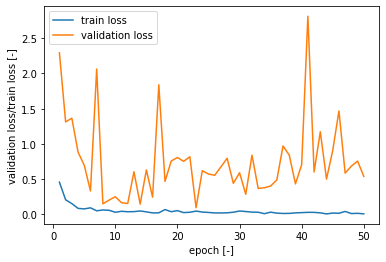

In [18]:
plt.figure()
plt.plot(range(1,51), train_loss, label = 'train loss')
plt.plot(range(1,51), val_loss, label = 'validation loss')
plt.xlabel('epoch [-]')
plt.ylabel('validation loss/train loss [-]')
plt.legend()

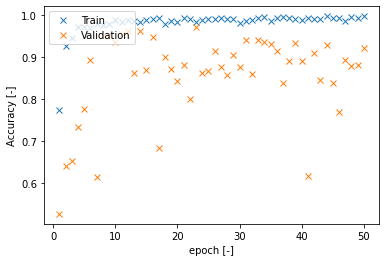

In [20]:
# Plot training & validation accuracy values
plt.plot(range(1,51),model_1.history['accuracy'],'x')
plt.plot(range(1,51),model_1.history['val_accuracy'],'x')
plt.ylabel('Accuracy [-]')
plt.xlabel('epoch [-]')
plt.legend(['Train', 'Validation', 'train loss','val loss'], loc='upper left')
plt.show()

In [24]:
def build_model(hp):
    model_opt = Sequential()
    model_opt.add(Conv2D(24, kernel_size=(4, 4), activation="relu",padding='same',input_shape = (100,200,1)))
    model_opt.add(MaxPooling2D((2, 2),padding='same'))
    model_opt.add(Conv2D(40, kernel_size=(4, 4), activation="relu",padding='same',input_shape = (100,200,1)))
    model_opt.add(Flatten())
    model_opt.add(Dense(2, activation="softmax"))
    
    model_opt.compile(
    optimizer=keras.optimizers.Adam(learning_rate = 0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],)
    return model_opt

In [25]:
tuner = RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=100,
    executions_per_trial=2,
    overwrite=True,
    directory='E:/',
    project_name='CNN_layer_learning_rate_data_augmentation',
)
tuner.search_space_summary()
tuner.search(x_train, y_train, epochs=50, validation_data=(x_val, y_val),batch_size = 16)

Trial 1 Complete [00h 32m 59s]
val_accuracy: 0.9864209592342377

Best val_accuracy So Far: 0.9864209592342377
Total elapsed time: 00h 32m 59s
INFO:tensorflow:Oracle triggered exit


In [26]:
#get the test data in an numpy-array
test = get_data('E:/Python Projekt 5_2 Extraktion/Dataset_split/Test')
x_test = []
y_test = []

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
x_test = np.array(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_test = np.array(y_test)

In [27]:
best_model = tuner.get_best_models()[0]
best_model.evaluate(x_test,y_test)

33/33 [==============================] - 1s 38ms/step - loss: 0.0706 - accuracy: 0.9748


[0.07058823108673096, 0.9748305678367615]

In [28]:
#get the predictions and calculate the recall and precision
predictions = best_model.predict(x_test)
y_test[:10]
tp = 0
fp = 0
fn = 0
tn = 0
for pred, label in zip(predictions,y_test):
    if pred[0] > 0.5 and label[0] == 1:
        tp +=1
    if pred[0] > 0.5 and label[0] == 0:
        fp +=1
    if pred[1] > 0.5 and label[0] == 1:
        fn +=1
    if pred[1] > 0.5 and label[0] == 0:
        tn +=1

print(f'There are {tp} true positive, {fp} false positive, {fn} false negativ and {tn} true negativ')
print('The calculations for the recall and the precision are:')
print('recall={}'.format(tp/(tp+fn)))
print('precision={}'.format(tp/(tp+fp)))

There are 534 true positive, 26 false positive, 0 false negativ and 473 true negativ
The calculations for the recall and the precision are:
recall=1.0
precision=0.9535714285714286
